In [150]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

def load_image(image_path, resize=True):
    # Load the image without resizing
    image = Image.open(image_path)
    if resize:
        image = image.resize((256, 256))  # Resize for model consistency
    return np.array(image) / 255.0  # Normalize and return image data


def load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center = float(box['x']) + 7.5  # 15/2 to get center
                y_center = float(box['y']) + 7.5  # 15/2 to get center
                x_min = (x_center - 7.5) / img_width
                y_min = (y_center - 7.5) / img_height
                x_max = (x_center + 7.5) / img_width
                y_max = (y_center + 7.5) / img_height
                labels.append([x_min, y_min, x_max, y_max])
        # Pad labels if less than num_boxes
        while len(labels) < num_boxes:
            labels.append([0, 0, 0, 0])  # Padding with dummy coordinates
    return labels






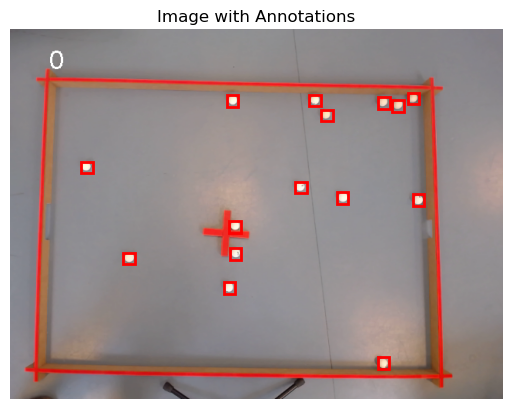

In [151]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

def display_image_with_annotations(image_path, json_path):
    # Load the image
    image = Image.open(image_path)
    # Assuming you want to work with the original size or resize as needed
    # image = image.resize((256, 256))  # Optional: Resize if required
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Load and draw annotations from JSON
    if json_path and os.path.exists(json_path):
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':  # Ensure we're only processing 'ball' annotations
                # Extract box information
                x_center = float(box['x'])
                y_center = float(box['y'])
                width = 15#float(box['width'])
                height = 15#float(box['height'])
                
                # Convert center coordinates to top-left corner, which is what matplotlib expects
                x = x_center - width / 2
                y = y_center - height / 2
                
                # Create a rectangle patch
                rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.title('Image with Annotations')
    plt.axis('off')  # Turn off axes for better visibility
    plt.show()

# Example usage
image_path = '../images/image_1.png'
json_path = '../json_labeling/label_1.json'
display_image_with_annotations(image_path, json_path)


In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape

def create_model(num_boxes=20, num_coords=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model




In [153]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error for bounding box regression
                  metrics=['mse', 'accuracy']) 

SyntaxError: unmatched ')' (1210494394.py, line 4)

In [ ]:
def data_generator(image_paths, json_paths, batch_size, num_boxes=20):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                image = load_image(image_paths[i])
                labels = load_labels_for_detection(json_paths[i], 256, 256, num_boxes)
                batch_images.append(image)
                batch_labels.append(labels)  # Add all labels for the image
            yield np.array(batch_images), np.array(batch_labels)



In [ ]:
def train_model(model, train_gen, steps_per_epoch, epochs=10):
    history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs)
    return history


In [155]:
# Define paths to your images and JSON files
image_paths = [f'../images/image_{i}.png' for i in range(1, 100)]
json_paths = [f'../json_labeling/label_{i}.json' for i in range(1, 100)]


# Create the model
model = create_model()

# Compile the model
compile_model(model)


# Create the data generator
batch_size = 32
train_gen = data_generator(image_paths, json_paths, batch_size)

# Train the model
history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // batch_size, epochs=10)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.4717
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.2701
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.2134 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.2360
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.2573
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.2688
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.2134 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.2359
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 0.2657
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.2753


In [154]:
def display_final_stats(history):
    # Get the final values of the metrics
    final_loss = history.history['loss'][-1]

    # Check available keys
    available_keys = history.history.keys()
    print(f"Available keys in history: {available_keys}")

    # Safely get the metrics based on available keys
    final_mse = history.history.get('mse', None)
    final_mean_squared_error = history.history.get('mean_squared_error', None)
    final_accuracy = history.history.get('accuracy', None)

    # Print training stats
    print(f"Final Training Loss: {final_loss:.4f}")
    if final_mse is not None:
        print(f"Final Training MSE: {final_mse[-1]:.4f}")
    elif final_mean_squared_error is not None:
        print(f"Final Training Mean Squared Error: {final_mean_squared_error[-1]:.4f}")
    if final_accuracy is not None:
        print(f"Final Training Accuracy: {final_accuracy[-1]:.4f}")

    # If validation was performed, display validation stats
    if 'val_loss' in history.history:
        final_val_loss = history.history['val_loss'][-1]
        final_val_mse = history.history.get('val_mse', None)
        final_val_mean_squared_error = history.history.get('val_mean_squared_error', None)
        final_val_accuracy = history.history.get('val_accuracy', None)

        # Print validation stats
        print(f"Final Validation Loss: {final_val_loss:.4f}")
        if final_val_mse is not None:
            print(f"Final Validation MSE: {final_val_mse[-1]:.4f}")
        elif final_val_mean_squared_error is not None:
            print(f"Final Validation Mean Squared Error: {final_val_mean_squared_error[-1]:.4f}")
        if final_val_accuracy is not None:
            print(f"Final Validation Accuracy: {final_val_accuracy[-1]:.4f}")

# Example usage after training the model
history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // batch_size, epochs=10)
display_final_stats(history)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.2757
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.2238 
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.2441
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.2649
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.2757
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.2238 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.2441
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.2649
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.2757
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.2238 
Available keys in history: dict_keys(['loss'])
Final Training Loss: 0.2433


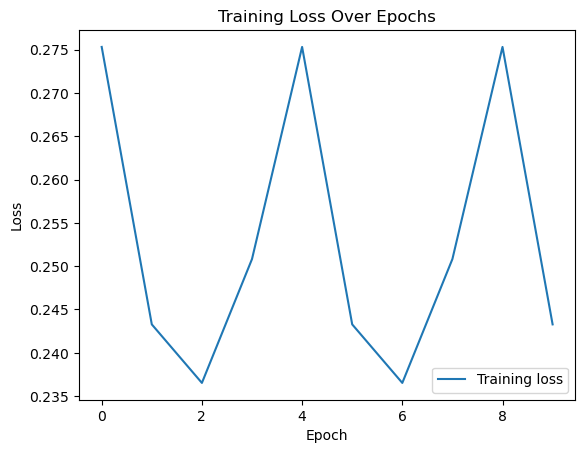

In [146]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call this function with your training history
plot_training_history(history)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


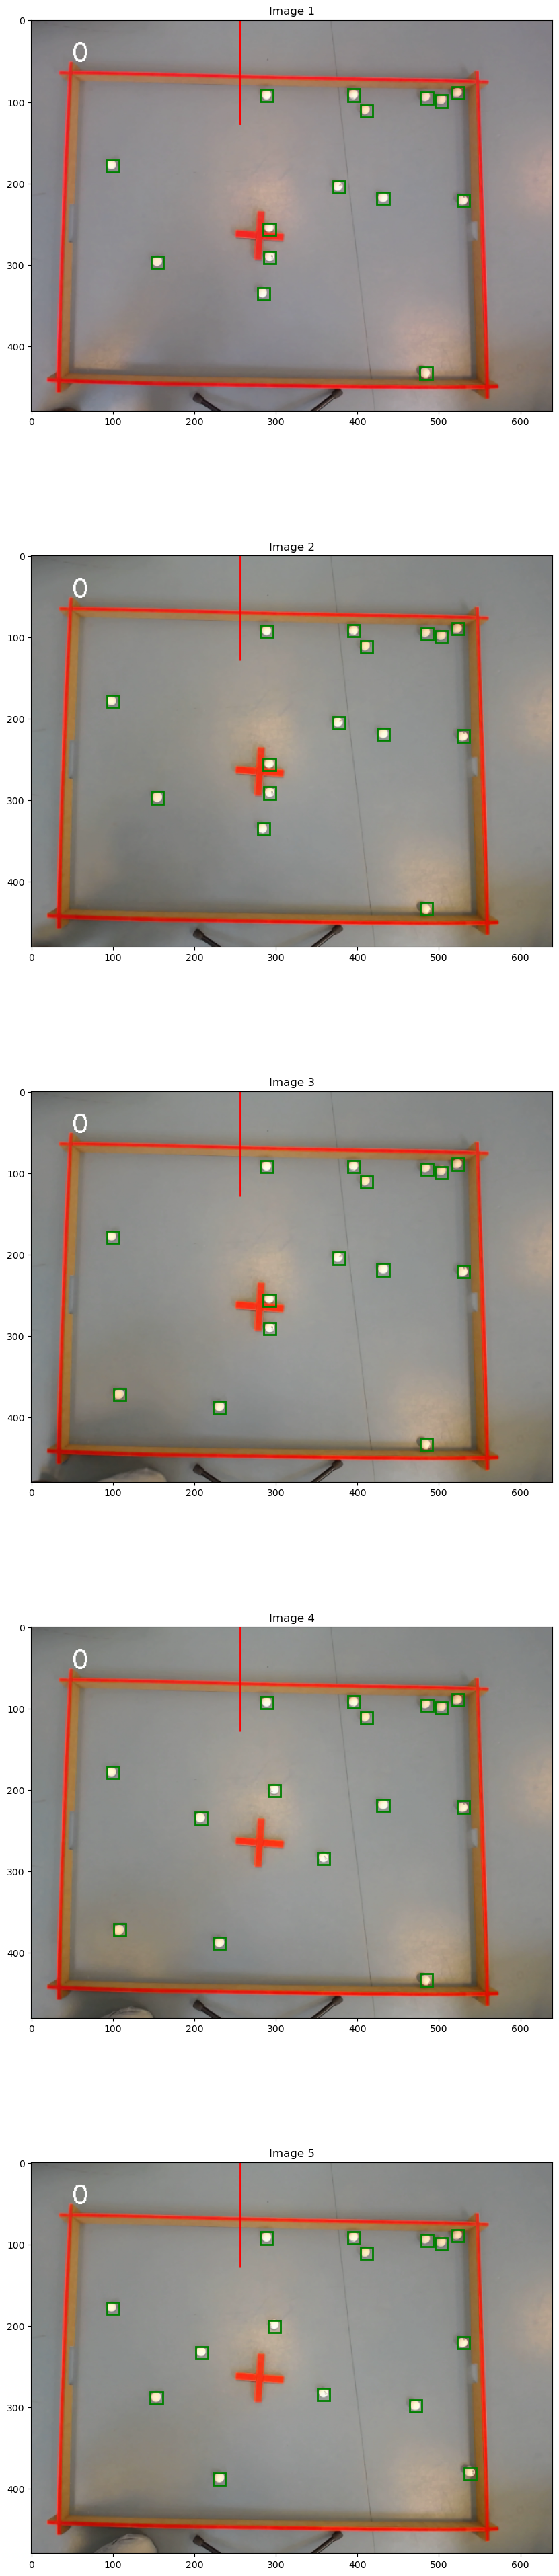

In [142]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



def show_predictions(model, image_paths, json_paths, num_samples=5, num_boxes=20):
    fig, axs = plt.subplots(num_samples, figsize=(10, num_samples * 10))
    for i in range(num_samples):
        original_image = load_image(image_paths[i], resize=False)
        model_input_image = load_image(image_paths[i], resize=True)  # Resized for the model
        img_height, img_width, _ = original_image.shape  # Get the original image dimensions

        true_labels = load_labels_for_detection(json_paths[i], img_width, img_height)
        predicted_labels = model.predict(model_input_image[np.newaxis, ...])[0]

        axs[i].imshow(original_image)
        # Draw true bounding boxes in green
        for label in true_labels:
            center_x = label[0] * img_width
            center_y = label[1] * img_height
            width = (label[2] - label[0]) * img_width
            height = (label[3] - label[1]) * img_height
            top_left_x = center_x - width / 2
            top_left_y = center_y - height / 2
            rect_true = patches.Rectangle((top_left_x, top_left_y),
                                          width,
                                          height, linewidth=2, edgecolor='g', facecolor='none')
            axs[i].add_patch(rect_true)
        # Draw predicted bounding boxes in red
        for pred in predicted_labels:
            center_x = pred[0] * 256
            center_y = pred[1] * 256
            width = (pred[2] - pred[0]) * 256
            height = (pred[3] - pred[1]) * 256
            top_left_x = center_x - width / 2
            top_left_y = center_y - height / 2
            rect_pred = patches.Rectangle((top_left_x, top_left_y),
                                          width,
                                          height, linewidth=2, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect_pred)

        axs[i].set_title(f'Image {i+1}')
    plt.show()

# Display model predictions
show_predictions(model, image_paths, json_paths)